In [2]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_score,recall_score,f1_score
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [4]:
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","Label"
]

training_data = pd.read_csv('/Users/younishubsey/desktop/kddcup.data_10_percent.csv',header = None)
test_data = pd.read_csv('/Users/younishubsey/desktop/corrected.csv',header = None)
test_data.columns = features
training_data.columns = features

In [6]:
test_data = test_data[test_data["Label"].isin(training_data["Label"].unique())]
print(test_data.shape)

(292300, 42)


In [8]:
duplicate_count_before = training_data.duplicated().sum()
training_data_no_duplicates = training_data.drop_duplicates()
duplicate_count_after = training_data_no_duplicates.duplicated().sum()
print(f"Number of duplicate rows before removal: {duplicate_count_before}")
print(f"Number of duplicate rows after removal: {duplicate_count_after}")

Number of duplicate rows before removal: 348435
Number of duplicate rows after removal: 0


In [10]:
attack_categories={
'normal.' : 'Normal',

'back.' : 'DoS', 'land.' : 'DoS', 'neptune.' : 'DoS', 'pod.' : 'DoS', 'smurf.' : 'DoS','teardrop.' : 'DoS',

'buffer_overflow.':'U2R', 'loadmodule.':'U2R', 'perl.':'U2R', 'rootkit.': 'U2R',

'ftp_write.' : 'R2L' , 'guess_passwd.':'R2L', 'imap.':'R2L', 'multihop.':'R2L', 'phf.':'R2L', 'spy.':'R2L', 'warezclient.':'R2L', 'warezmaster.':'R2L',

'ipsweep.':'Probing', 'nmap.':'Probing', 'portsweep.':'Probing', 'satan.': 'Probing'
}

training_data['attack_sections']=training_data['Label'].map(attack_categories)
test_data['attack_sections']=test_data['Label'].map(attack_categories)

In [12]:
training_data['attack_sections'] = training_data['Label'].map(attack_categories)
test_data['attack_sections'] = test_data['Label'].map(attack_categories)
print(training_data['attack_sections'].value_counts())

attack_sections
DoS        391458
Normal      97278
Probing      4107
R2L          1126
U2R            52
Name: count, dtype: int64


In [14]:
print(training_data['attack_sections'].value_counts(normalize=True))

attack_sections
DoS        0.792391
Normal     0.196911
Probing    0.008313
R2L        0.002279
U2R        0.000105
Name: proportion, dtype: float64


In [16]:
training_data = training_data[training_data['attack_sections'] != 'U2R']

In [18]:
test_data = test_data[test_data['attack_sections'] != 'U2R']

In [20]:
from sklearn.preprocessing import LabelEncoder
our_categorical_columns = ["Label","attack_sections"]
label_encoder = LabelEncoder()
for col in our_categorical_columns:
    training_data[col]=label_encoder.fit_transform(training_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [22]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ["protocol_type","service", "flag"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
train_ohe = encoder.fit_transform(training_data[categorical_features])
test_ohe = encoder.transform(test_data[categorical_features])
train_encoded_df = pd.DataFrame(train_ohe, columns=encoder.get_feature_names_out(categorical_features))
test_encoded_df = pd.DataFrame(test_ohe, columns=encoder.get_feature_names_out(categorical_features))
training_data = training_data.drop(columns=categorical_features).reset_index(drop=True)
test_data = test_data.drop(columns=categorical_features).reset_index(drop=True)
training_data = pd.concat([training_data, train_encoded_df], axis=1)
test_data = pd.concat([test_data, test_encoded_df], axis=1)


In [24]:
x_train =training_data.drop(columns=['Label','attack_sections'])
y_train = training_data['attack_sections']
x_test = test_data.drop(columns=['Label','attack_sections'])
y_test = test_data['attack_sections']

In [26]:
feature_drop = [
    
 
    
    'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login',

   
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'

]

x_train_select = x_train.drop(columns=feature_drop)
x_test_select = x_test.drop(columns=feature_drop)

In [28]:
print(y_train.value_counts())

attack_sections
0    391458
1     97278
2      4107
3      1126
Name: count, dtype: int64


In [30]:
sampling = {2:40000,3:391400}
smote_tomek = SMOTETomek(sampling_strategy = sampling,random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(x_train_select, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [31]:
y_resampled.value_counts()

attack_sections
0    391435
3    391326
1     97173
2     39980
Name: count, dtype: int64

In [31]:
from xgboost import XGBClassifier
import xgboost as xgb
The_best_params = {
    "max_depth": 1,               
    "learning_rate": 0.1,         
    "n_estimators": 230,         
    "subsample": 0.7,           
    "colsample_bytree": 0.7,      
    "reg_lambda": 10,
    "reg_alpha": 0.1,
}

xgb_model = XGBClassifier(
    **The_best_params,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42,
)
xgb_model.fit(X_resampled, y_resampled)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = xgb_model.predict(x_test_select)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))


accuracy = accuracy_score(y_test, y_pred)
print(f"\n accuracy: {accuracy:.4f}")


 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223298
           1       1.00      0.96      0.98     60593
           2       0.84      1.00      0.91      2377
           3       0.84      0.99      0.91      5993

    accuracy                           0.99    292261
   macro avg       0.92      0.99      0.95    292261
weighted avg       0.99      0.99      0.99    292261


 accuracy: 0.9909


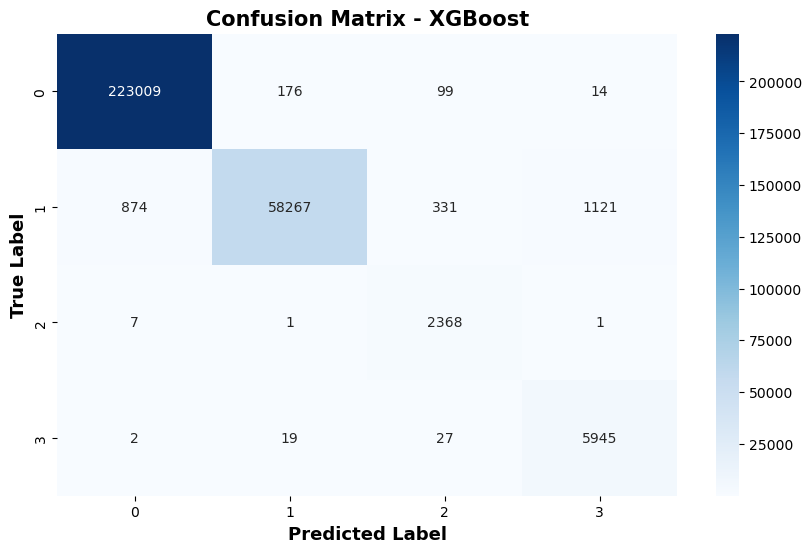

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label",fontweight="bold",fontsize=13)
plt.ylabel("True Label",fontweight="bold",fontsize=13)
plt.title("Confusion Matrix - XGBoost",fontsize=15,fontweight="bold")
plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


random_forest_model = RandomForestClassifier(
    n_estimators=1200,  
    max_depth= 8,       
    random_state=42,
    n_jobs=-1,
    bootstrap = True,
    max_features = 0.7,
    min_samples_leaf = 1,
    min_samples_split = 2,

    
)
random_forest_model.fit(X_resampled, y_resampled)


y_pred_rf = random_forest_model.predict(x_test_select)


print(" Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223298
           1       1.00      0.98      0.99     60593
           2       0.81      1.00      0.89      2377
           3       0.87      0.99      0.92      5993

    accuracy                           0.99    292261
   macro avg       0.92      0.99      0.95    292261
weighted avg       1.00      0.99      0.99    292261



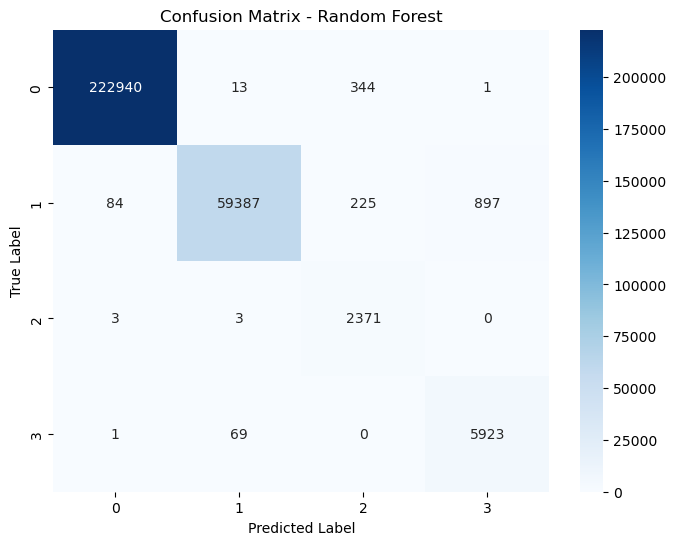

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [35]:
!pip install lightgbm


In [36]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lightgbm_model = LGBMClassifier(
    n_estimators=300,  
    max_depth=6, 
    lambda_l2 = 2,
    random_state=42,
    n_jobs=-1,
    boosting_type="dart",  
    num_leaves=20, 
    learning_rate=0.01,  
    min_child_samples=5,
    verbose = -1
)

lightgbm_model.fit(X_resampled, y_resampled)


y_pred_lgb = lightgbm_model.predict(x_test_select)


print(" LightGBM Classification Report:\n")
print(classification_report(y_test, y_pred_lgb))

 LightGBM Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223298
           1       1.00      0.97      0.98     60593
           2       0.83      0.99      0.90      2377
           3       0.85      1.00      0.92      5993

    accuracy                           0.99    292261
   macro avg       0.92      0.99      0.95    292261
weighted avg       0.99      0.99      0.99    292261



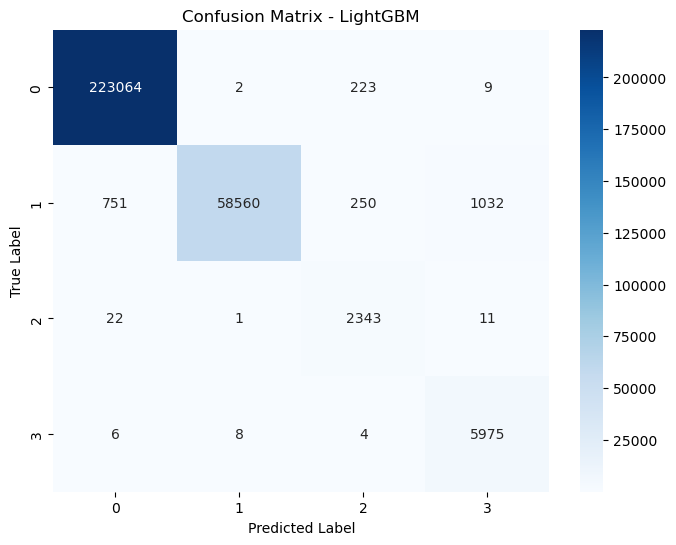

In [37]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()


In [38]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [39]:
randomforest_params = {
    "n_estimators": [1200,100],
    "max_depth": [6,40], 
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1],
    "max_features" :[0.7]
}

xgboost_params = {
    "max_depth": [1,8],               
    "learning_rate": [0.1,0.01],         
    "n_estimators": [230],         
    "subsample": [0.7],           
    "colsample_bytree": [0.7],      
    "reg_lambda": [10,15],
    "reg_alpha": [0.1],
}

Lightgbm_params =  {
    "n_estimators": [300],  
    "max_depth" :[6,15],
    "lambda_l2" : [2],
    "boosting_type":["dart"],  
    "num_leaves" : [20,15], 
    "learning_rate" : [0.01,0.1],  
    "min_child_samples":[5,1],
}
    
xg_boost_model = XGBClassifier(random_state = 42,n_jobs =-1)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lightgbm= LGBMClassifier(random_state=42,n_jobs = -1)

In [40]:
rf_grid_search = GridSearchCV(
    rf_model, 
    param_grid=randomforest_params, 
    cv=skf,  
    scoring="recall_macro",  
    verbose=2, 
    n_jobs=-1  
)
rf_grid_search.fit(X_resampled, y_resampled)
print("Best RF Parameters:", rf_grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_depth=6, max_features=0.7, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=37.9min
[CV] END max_depth=40, max_features=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.0min
[CV] END max_depth=40, max_features=0.7, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 5.4min
[CV] END max_depth=6, max_features=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=37.9min
[CV] END max_depth=40, max_features=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.9min
[CV] END max_depth=40, max_features=0.7, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 5.3min
[CV] END max_depth=40, max_features=0.7, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 3.6min
[CV] END max_depth=6, max_features=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=100; tota

In [41]:
xg_grid_search = GridSearchCV(
    xg_boost_model, 
    param_grid=xgboost_params, 
    cv=skf,  
    scoring="recall_macro",  
    verbose=2, 
    n_jobs=-1  
)
xg_grid_search.fit(X_resampled, y_resampled)
print("Best xg Parameters:", xg_grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best xg Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 230, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.7}


In [42]:
light_grid_search = GridSearchCV(
    lightgbm, 
    param_grid=Lightgbm_params, 
    cv=skf,  
    scoring="recall_macro",  
    verbose=2, 
    n_jobs=-1  
)
light_grid_search.fit(X_resampled, y_resampled)
print("Best light Parameters:", light_grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=1, n_estimators=230, reg_alpha=0.1, reg_lambda=10, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=8, n_estimators=230, reg_alpha=0.1, reg_lambda=15, subsample=0.7; total time= 2.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=8, n_estimators=230, reg_alpha=0.1, reg_lambda=10, subsample=0.7; total time= 1.7min
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6829
[LightGBM] [Info] Number of data points in 